**SETTING DIRECTORY & DOWNLOAD DATASET FROM KAGGLE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/IDMB-Classfication/

/content/drive/MyDrive/IDMB-Classfication


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chophm","key":"1fecc45e8d8d8b8e0737ac9db51f96f4"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 82% 21.0M/25.7M [00:00<00:00, 115MB/s] 
100% 25.7M/25.7M [00:00<00:00, 120MB/s]


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip



Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer

stopwords = set(stopwords.words('english'))
# stopwords.remove('not')

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**READ DATA FROM FILE**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/IDMB-Classfication/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 966340.43it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
data.sentiment.value_counts()


positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))


100%|██████████| 50000/50000 [00:01<00:00, 42185.95it/s]


In [ ]:
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [ ]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

**TEXT CLEANING AND PROCESSING**

In [ ]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)
def rp_negative(text):
    t = re.sub("n't", ' nott', text)
    return re.sub("n'", ' nott',t)
# print(rp_negative("the film wasn't"))
# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    no_link = rm_link(text)
    re_neg = rp_negative(no_link)
    no_html = rm_html(re_neg)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [ ]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    # stopwords =
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # print(lemmas)
    # make sure lemmas does not contains sotpwords
    lemmas = rm_stopwords(lemmas)
    return lemmas
def stem(text):
    stemm = PorterStemmer()
    stem = [stemm.stem(t) for t in text]
    stem = rm_stopwords(stem)
    return stem
def preprocess_pipeline(text):
    tokens = tokenize(text)
    # print(tokens)

    # lemmas = lemmatize(tokens)

    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [ ]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
print(data['clean'][1])
print(data['processed'][1])

100%|██████████| 50000/50000 [02:07<00:00, 392.84it/s]

A wonderful little production . The filming technique is very unassuming - very old - time - BBC fashion and gives a comforting , and sometimes discomforting , sense of realism to the entire piece . The actors are extremely well chosen - Michael Sheen not only has got all the polari but he has all the voices down pat too ! You can truly see the seamless editing guided by the references to Williams diary entries , not only is it well worth the watching but it is a terrificly written and performed piece . A masterful production about one of the great master s of comedy and his life . The realism really comes home with the little things the fantasy of the guard which , rather than use the traditional dream techniques remains solid then disappears . It plays on our knowledge and our senses , particularly with the scenes concerning Orton and Halliwell and the sets particularly of their flat with Halliwell s murals decorating every surface are terribly well done . 
A wonderful little product

In [ ]:
print(preprocess_pipeline("hao has"))

hao


In [ ]:
print(data['review'][1])
print(data['clean'][1])
print(data['processed'][1])

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.
A

In [ ]:
data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)


**PREPARE DATASET**

In [ ]:
# read processed data
data = pd.read_csv('./imdb_processed.csv')
# data_predict = pd.read_csv('./final_processing.csv')
for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')
    print('\n')

One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show would nott dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ nott mess around . The first episode I ever saw struck nasty surreal , I could nott say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice

In [ ]:
data = pd.read_csv('./imdb_processed.csv')
print(data['processed'][1])
data_predict = pd.read_csv('/content/drive/MyDrive/IDMB-Classfication/final_processing.csv')
print(data_predict['processed'][1])

A wonderful little production . The filming technique unassuming - old - time - BBC fashion give comforting , sometimes discomforting , sense realism entire piece . The actor extremely well chosen - Michael Sheen got polari voice pat ! You truly see seamless editing guided reference Williams diary entry , well worth watching terrificly written performed piece . A masterful production one great master comedy life . The realism really come home little thing fantasy guard , rather use traditional dream technique remains solid disappears . It play knowledge sens , particularly scene concerning Orton Halliwell set particularly flat Halliwell mural decorating every surface terribly well done .
Up point , one trilogy MCU excellent start finish . It time add another one list . Guardians Galaxy Vol . fitting conclusion narrative character . James Gunn writer director took time creating connection depth individual story - arc . While recent film MCU felt like filler episode whose purpose solely 

In [ ]:
# get all processed reviews
reviews = data.processed.values
# words = ' '.join(reviews)
reviews_pr =  data_predict.processed.values
full_word = np.concatenate((reviews, reviews_pr))
print(len(reviews))
# merge into single variable, separated by whitespaces
words = ' '.join(full_word)
# obtain list of words
words = words.split()

# check our list
len(words)

50000


10187349

In [ ]:
# build vocabulary
counter = Counter(words)
# print(counter)
vocab = sorted(counter, key=counter.get, reverse=True)
# print(vocab)
int2word = dict(enumerate(vocab, 1))
# print(int2word)
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}
print(word2int)

{'.': 1, ',': 2, 'I': 3, '-': 4, 'movie': 5, 'film': 6, 'The': 7, 'nott': 8, 'one': 9, '!': 10, 'like': 11, 'It': 12, 'time': 13, '?': 14, 'character': 15, 'This': 16, 'good': 17, 'story': 18, 'would': 19, 'make': 20, 'get': 21, 'see': 22, 'really': 23, 'scene': 24, 'even': 25, 'much': 26, 'well': 27, 'great': 28, 'way': 29, 'could': 30, 'people': 31, 'also': 32, 'first': 33, 'thing': 34, 'bad': 35, 'made': 36, 'life': 37, 'show': 38, 'think': 39, 'But': 40, 'know': 41, 'go': 42, 'And': 43, 'year': 44, 'watch': 45, 'A': 46, 'many': 47, 'love': 48, 'seen': 49, 'plot': 50, 'actor': 51, 'say': 52, 'best': 53, 'end': 54, 'two': 55, 'There': 56, 'never': 57, 'acting': 58, 'look': 59, 'In': 60, 'little': 61, 'work': 62, 'take': 63, 'better': 64, 'ever': 65, 'He': 66, 'come': 67, 'If': 68, 'still': 69, 'performance': 70, 'part': 71, 'something': 72, 'lot': 73, 'find': 74, 'want': 75, 'give': 76, 'back': 77, 'man': 78, 'action': 79, 'real': 80, 'role': 81, 'director': 82, 'feel': 83, 'play': 8

In [ ]:
# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# print first-10 words of first 5 reviews
for i in range(5):
    print(len(reviews_enc[i]))


100%|██████████| 50000/50000 [00:01<00:00, 30626.28it/s]

233
109
108
84
160


In [ ]:
print(reviews_enc[1])

[46, 330, 61, 260, 1, 7, 1336, 1675, 17011, 4, 89, 4, 13, 4, 2392, 1356, 76, 12312, 2, 519, 24987, 2, 189, 1707, 337, 242, 1, 7, 51, 472, 27, 2141, 4, 374, 3790, 112, 78868, 398, 8516, 10, 119, 273, 22, 8995, 680, 9441, 1053, 1305, 7883, 1962, 2, 27, 206, 86, 39981, 316, 2286, 242, 1, 46, 3468, 260, 9, 28, 1293, 102, 37, 1, 7, 1707, 23, 67, 267, 61, 34, 801, 2221, 2, 178, 258, 2032, 543, 1675, 1170, 866, 4800, 1, 12, 84, 1752, 4265, 2, 496, 24, 3953, 22785, 28942, 122, 496, 936, 28942, 28943, 28944, 96, 2046, 2055, 27, 133, 1]


In [ ]:
# each review get 256 first elements.
def pad_features(reviews, pad_id, seq_length=256):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features
seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features.shape

(50000, 256)

In [ ]:
# get labels as numpy
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
# train test split
train_size = .7     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [ ]:
# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [ ]:
# check our batches
dataiter = iter(trainloader)
x, y = next(dataiter)

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[  16,  147, 9268,  ...,    0,    0,    0],
        [  16,    6,   23,  ...,    0,    0,    0],
        [  16,    5, 3435,  ...,    0,    0,    0],
        ...,
        [ 918,   79,   38,  ...,    0,    0,    0],
        [   7,  217, 8409,  ...,    0,    0,    0],
        [   3,  219,  303,  ...,    0,    0,    0]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0])


In [ ]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # n_layers of LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

In [ ]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(135387, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# training config
lr = 0.001
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 6
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

In [ ]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm_6.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:  17%|█▋        | 1/6 [01:11<05:59, 71.88s/it, Val Loss: 0.694 | Val Acc: 0.494]

Epoch 1/6 | Train Loss: 0.694 Train Acc: 0.499 | Val Loss: 0.694 Val Acc: 0.494


Training:  50%|█████     | 3/6 [02:23<02:26, 48.83s/it, Val Loss: 0.693 | Val Acc: 0.508]

Epoch 2/6 | Train Loss: 0.694 Train Acc: 0.501 | Val Loss: 0.693 Val Acc: 0.508


Training:  83%|████████▎ | 5/6 [03:35<00:58, 58.03s/it, Training batch 0/274]            

Epoch 3/6 | Train Loss: 0.692 Train Acc: 0.510 | Val Loss: 0.695 Val Acc: 0.505
[WARNING] Validation loss did not improved (0.693 --> 0.695)


Training: 100%|██████████| 6/6 [04:47<00:00, 46.31s/it, Val Loss: 0.466 | Val Acc: 0.796]

Epoch 4/6 | Train Loss: 0.635 Train Acc: 0.591 | Val Loss: 0.466 Val Acc: 0.796


Training: 7it [06:00, 53.49s/it, Val Loss: 0.341 | Val Acc: 0.857]                       

Epoch 5/6 | Train Loss: 0.361 Train Acc: 0.844 | Val Loss: 0.341 Val Acc: 0.857


Training: 9it [07:12, 48.12s/it, Val Loss: 0.329 | Val Acc: 0.872]

Epoch 6/6 | Train Loss: 0.226 Train Acc: 0.916 | Val Loss: 0.329 Val Acc: 0.872


Training: 100%|██████████| 6/6 [07:13<00:00, 72.17s/it, Val Loss: 0.329 | Val Acc: 0.872]


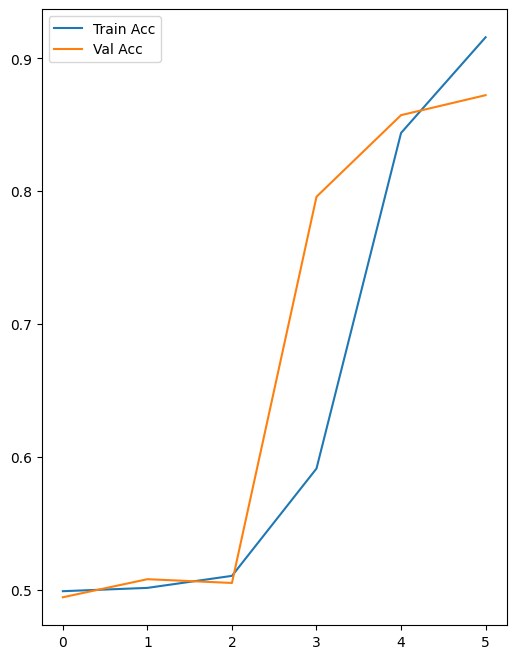

In [ ]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

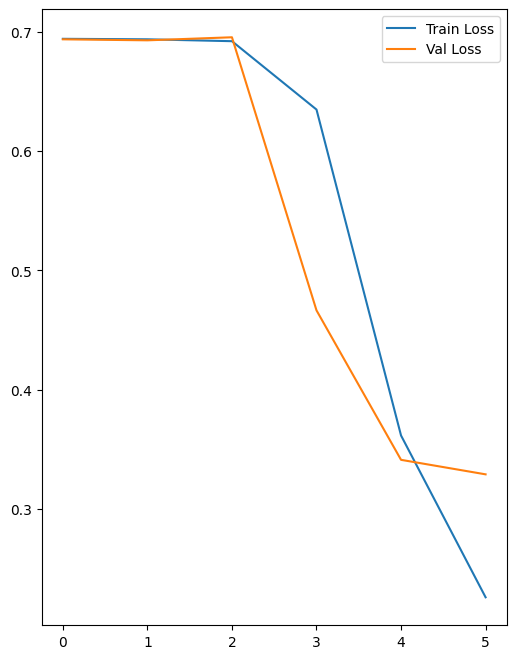

In [ ]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)
        print(type(feature))
        out = model(feature)

        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference:   2%|▏         | 1/59 [00:00<00:07,  7.62it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:   5%|▌         | 3/59 [00:00<00:05, 10.12it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  12%|█▏        | 7/59 [00:00<00:04, 11.69it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  15%|█▌        | 9/59 [00:00<00:04, 11.93it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  22%|██▏       | 13/59 [00:01<00:03, 12.23it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  25%|██▌       | 15/59 [00:01<00:03, 12.27it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  32%|███▏      | 19/59 [00:01<00:03, 12.29it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  36%|███▌      | 21/59 [00:01<00:03, 12.30it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  42%|████▏     | 25/59 [00:02<00:02, 12.26it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  46%|████▌     | 27/59 [00:02<00:02, 12.22it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  53%|█████▎    | 31/59 [00:02<00:02, 12.26it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  56%|█████▌    | 33/59 [00:02<00:02, 12.32it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  63%|██████▎   | 37/59 [00:03<00:01, 12.31it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  66%|██████▌   | 39/59 [00:03<00:01, 12.31it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  73%|███████▎  | 43/59 [00:03<00:01, 12.34it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  76%|███████▋  | 45/59 [00:03<00:01, 12.30it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  83%|████████▎ | 49/59 [00:04<00:00, 12.06it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  86%|████████▋ | 51/59 [00:04<00:00, 12.06it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  93%|█████████▎| 55/59 [00:04<00:00, 12.05it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference:  97%|█████████▋| 57/59 [00:04<00:00, 12.00it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


Inference: 100%|██████████| 59/59 [00:04<00:00, 12.12it/s]

Accuracy: 0.8733, Loss: 0.3241


**PREDICT DATA FROM CRAWLER**

In [ ]:
checkpoint = torch.load('sentiment_lstm_6.pt')
print(checkpoint)

# model = model.to(device)

In [ ]:
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [ ]:
model.to(device)

SentimentModel(
  (embedding): Embedding(135387, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
model.eval()
data_pre = pd.read_csv('./final_processing.csv')
i = 0
pre_csv = []
with torch.no_grad():
    for review in tqdm(data_pre['processed']):
        encode = [[word2int[word] for word in review.split()]]
        # print(encode)
        feature = pad_features(encode, pad_id=word2int['<PAD>'], seq_length=seq_length)
        feature = torch.from_numpy(feature)
        i += 1
        feature = feature.to(device)
        pre = model(feature)
        predicted = torch.tensor([1 if i == True else 0 for i in pre > 0.5], device=device)
        str_pre = 'positive' if predicted == torch.tensor([1], device = device) else 'negative'
        # print('Review {}:  '.format(i), str_pre)
        pre_csv.append(
            str_pre
        )
data_pre['predicted'] = pre_csv


100%|██████████| 11207/11207 [02:04<00:00, 90.26it/s]


In [ ]:
data_pre[['film','processed','predicted']].to_csv('./final_predicted.csv', index = False, header = True)

In [ ]:
predict_csv = pd.read_csv('./final_predicted.csv')
predict_csv['film'].value_counts().sort_index()

film_0    25
film_1    25
film_2    25
film_3    25
film_4    25
          ..
lm_493    25
lm_495    25
lm_496    25
lm_497    25
lm_498    25
Name: film, Length: 455, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

films = predict_csv[(predict_csv["predicted"] == "positive")].groupby("film").count()
# print(films.predicted)

ne_films = predict_csv[predict_csv["predicted"] == "negative"].groupby("film").count()
# print(ne_films.predicted)

merge = pd.merge(films, ne_films, on = "film")
merge.head(10)

,processed_x,predicted_x,processed_y,predicted_y
film,,,,
film_0,21,21,4,4
film_1,7,7,18,18
film_2,4,4,21,21
film_3,22,22,3,3
film_4,21,21,4,4
film_5,24,24,1,1
film_6,7,7,18,18
film_7,24,24,1,1
film_9,19,19,6,6
